In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

nsamps=1024

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


X_all = pd.concat((X_1, X_0), ignore_index=True)

X_all = X_all.reindex(np.random.permutation(X_all.index))

X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [3]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def lr_cost(X, theta, y):
    est = sig(X, theta)
    log_est = np.log(est)
    cost = y*log_est + (1-y) * (1-log_est)
    cost *= -1
    return cost

def cost_ss(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    return cost

def grad(X, theta, y):
    diff = y - sig(X, theta)
    g = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j  in range(X.shape[1]):
            g[i,j] = diff[i] * X[i,j]
    return g

def fit_params(X, y, theta):
    tol = 1e-5
    learning_rate = 1e-2
    costs = [np.inf]
    for i in range(0, 1000):
        my_cost = lr_cost(X, theta, y)
        my_cost = my_cost.sum()
        costs.append(my_cost)
        if abs(my_cost - costs[-2]) < tol:
            break
        else:
            my_gradient = grad(X, theta, y)
            my_gradient = my_gradient.mean(axis=0)
            theta = theta + learning_rate * my_gradient
            
    return theta, costs

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.6)

new_t = np.random.normal(size=(X_train.shape[1], )).astype(np.float32)

fitted_theta, outcost = fit_params(X_train.values, 
                                   y_train.values, 
                                   new_t)

In [5]:
fitted_theta

array([ 0.0446463 ,  1.02113246])

In [9]:
print('cost on test set: ', lr_cost(X_test.values, fitted_theta, y_test.values).sum())
print('average sum of square error on test set: ',cost_ss(sig(X_test.values, fitted_theta), y_test.values).sum()/X_test.shape[0])

cost on test set:  -2514.30615455
average sum of square error on test set:  0.0197783443436


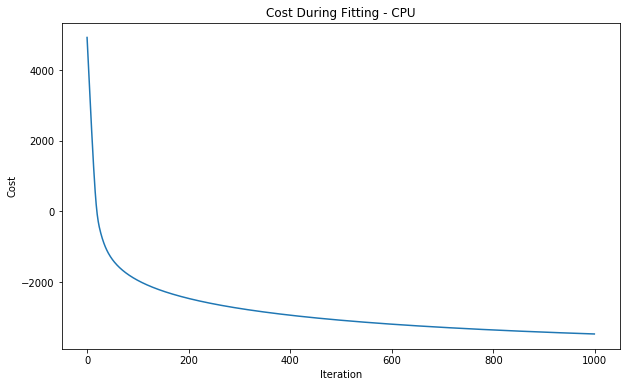

In [11]:
plt.figure(figsize=(10,6))
plt.plot(outcost[1:])
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost During Fitting - CPU')
plt.show()